# Laboratorio 3 Aprendizaje por refuerzo: DQN
## Integrantes: Agustin Haristoy, Cristhofer Parada

En esta entrega, es solicitado realizar un agente DQN para resolver el entorno de Bomberman.


In [40]:
# en este espacio, coloque la direccion de la carpeta raíz de donde se encuentra los archivos de texto
# o mejor dicho donde esta descomprimido los archivos de las posiciones de las cajas
file_str = ""

# Bomberman Environment 

In [1]:
import gym
from gym import spaces
import numpy as np
import pygame
import matplotlib.pyplot as plt


class Item(object):
    def __init__(self,pos):
        self.pos = pos

class Box(Item):
    def __init__(self,pos,breakable,broken,target):
        super(Box,self).__init__(pos)
        self.isBreakable = breakable
        self.isTarget = target
        self.isBroken = broken

    def get_state(self):
        return (self.pos, self.isBreakable, self.isTarget,self.isBroken)
    
class Enemy(Item):
    def __init__(self,pos,orientation,way,isAlive):
        super(Enemy,self).__init__(pos)
        self.orientation = orientation
        self.way = way
        self.isAlive = isAlive


    def get_state(self):
        return (self.pos, self.orientation, self.way, self.isAlive)
    


class Bomb(Item):
    def __init__(self,pos,timer):
        super(Bomb,self).__init__(pos)
        self.timer = timer

    def get_state(self):
        return (self.pos, self.timer)


class Explosion(Item):
    def __init__(self,pos):
        super(Explosion,self).__init__(pos)

    def get_state(self):
        return (self.pos)

def mult(x,y):
        if(x > y):
            multi = x/y
        else:
            multi = y/x
        return multi

def exist(list,pos):
    for i in range(len(list)):
        if(pos[0] == list[i].pos[0] and pos[1] == list[i].pos[1]):
            return True
    return False

def index(list,pos):
    for i in range(len(list)):
        if(pos[0] == list[i].pos[0] and pos[1] == list[i].pos[1]):
            return i

class BombermanEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 3}

    def __init__(self, width, height, boxes, enemies_x, enemies_y, rompible_file, render_mode = None):
        super(BombermanEnv, self).__init__()

        self.width = width
        self.height = height
        if boxes < 1:
            print("El numero de cajas debe ser mayor que 1.")
            return 
        self.list_boxes = [] # lista para las cajas rompibles e irrompibles
        self.boxes = boxes # total de cajas rompibles
        self.list_boxes_breakable = [] # lista para las cajas rompibles 
        self.list_enemies = [] # lista que contendra a los enemigos
        self.enemies_x = enemies_x # total de enemigos horizontales
        self.enemies_y = enemies_y # total de enemigos verticales
        self.rompible_file = rompible_file # archivo de cajas irrompibles
        self._agent_location = np.array([0,0])
        self.active_bomb = 0
        self.observation = self._get_obs()
        m = mult(self.width, self.height)
        if(self.width > self.height):
            self.window_height = 670
            self.window_width = m * self.window_height
        else:
            self.window_width = 512
            self.window_height = m * self.window_width
            
        # Define la forma del espacio de observación (en este caso, una imagen binaria)
        self.observation_space = spaces.Box(low=0, high=1, shape=(len(self.observation),), dtype=np.float32)

        # Define el espacio de acción (puedes personalizar esto según tu entorno)
        self.action_space = spaces.Discrete(6)  # Ejemplo: acciones discretas 0, 1, 2, 3

        self._action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([0, 1]),
            2: np.array([-1, 0]),
            3: np.array([0, -1]),
            4: np.array([0, 0]),
            5: np.array([0, 0]),
        }
        self._action_to_names = {
            0: 'RIGHT',
            1: 'DOWN',
            2: 'LEFT',
            3: 'UP',
            4: 'BOMB',
            5: 'WAIT',
        }
        

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        # Define cualquier otro atributo específico de tu entorno
        self.window = None
        self.clock = None

        # Inicializa el estado inicial de tu entorno
        #self.state = np.zeros((width, height), dtype=np.float32)

    def distance(self, pos1, pos2):
        # buscamos la distancia entre el agente y un obstaculo
        return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)
    
    def find_closest_obstacle(self, agent_position):
        """Encuentra la posición del obstáculo más cercano a la posición del agente."""
        closest_obstacle = None
        min_distance = float('inf')  # Inicializar con infinito para asegurar que cualquier distancia sea menor

        # Iterar sobre las cajas rompibles e irrompibles para encontrar la más cercana al agente
        for box in self.list_boxes + self.list_boxes_breakable:
            obstacle_position = box.pos
            d = self.distance(agent_position, obstacle_position)
            if d < min_distance:
                min_distance = d
                closest_obstacle = obstacle_position

        return closest_obstacle


    

    def _tile_is_free(self,direction):
        movement = self._agent_location + direction
        if (exist(self.list_boxes,movement)):
            if(self.list_boxes[index(self.list_boxes,movement)].isBreakable and self.list_boxes[index(self.list_boxes,movement)].isBroken):
                return True
            elif(self.list_boxes[index(self.list_boxes,movement)].isBreakable and not(self.list_boxes[index(self.list_boxes,movement)].isBroken)):
                return False
            else:
                return False
        return True

    def _get_obs(self):
        agent_position = self._agent_location
        closest_obstacle = self.find_closest_obstacle(agent_position)
        bomb_position = self.bomb.pos if self.active_bomb == 1 else np.array([0, 0])

        # Verificar si closest_obstacle no es None antes de aplanarlo
        if closest_obstacle is not None:
            closest_obstacle = closest_obstacle.flatten()
        else:
            # Si no hay obstáculo cercano, puedes proporcionar algún valor por defecto
            closest_obstacle = np.zeros_like(agent_position)

        # Aplana la información en un solo array
        flattened_observation = np.concatenate((
            agent_position.flatten(),
            closest_obstacle.flatten(),
            bomb_position.flatten()
        ))

        return np.array(flattened_observation)
    
    def _get_info(self):
        return {
            "distance": np.linalg.norm(
                np.array(self._agent_location) - np.array(self._target_location), ord=1
            )
        }
    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        self.list_boxes = [] # lista para las cajas rompibles e irrompibles
        self.list_boxes_breakable = [] # lista para las cajas rompibles
        self.list_enemies = [] # lista que contendra a los enemigos
        self.active_explosion = 0
        self.active_bomb = 0
        self.player_alive = True 
        self.bomb = Bomb(np.array([0,0]),0)
        self.explosion_radius = []
        # generamos las cajas irrompibles
        for i in range(self.width):
            for j in range(self.height):                        
                if ((i % 2 == 1) and (j % 2 == 1)):
                    self.list_boxes.append(Box(np.array([i,j]),False,False,False))
        
        # generamos las cajas rompibles
        if not self.rompible_file == '':
            rompible_info = []
            with open(self.rompible_file, "r") as file:
                for line in file:
                    rompible_info.append(line.strip())
            if not rompible_info == []:
                if len(rompible_info) == self.boxes:
                # Procesa la información y genera cajas irrompibles
                    rompible_coordinates = []
                    for line in rompible_info:
                        x, y = map(int, line.split(","))
                        rompible_coordinates.append((x, y))
                    for coordinates in rompible_coordinates:
                        self.list_boxes.append(Box(np.array(coordinates), True, False,False))
                        self.list_boxes_breakable.append(Box(np.array(coordinates), True, False,False))
        else:
            i=0
            while i < self.boxes:
                box_pos = np.array([self.np_random.integers(0,self.width-1,dtype=int),self.np_random.integers(0,self.height-1,dtype=int)])
                for j in range(len(self.list_boxes)):
                    if not (exist(self.list_boxes,box_pos)):
                        self.list_boxes.append(Box(box_pos,True,False,False))
                        self.list_boxes_breakable.append(Box(box_pos,True,False,False))
                        i+=1

        '''for i in range(len(self.list_boxes_breakable)):
            print(self.list_boxes_breakable[i].pos)'''
        # Choose the agent's location uniformly at random
        '''aux = True
        while (aux):
            x = self.np_random.integers(0, self.width, dtype=int)
            y = self.np_random.integers(0, self.height, dtype=int)
            if not (exist(self.list_boxes,np.array([x,y]))):
                aux = False
                self._agent_location = np.array([x,y])
            '''
        self._agent_location = np.array([2,2])

        # Choose target location between breakable boxes
        target_box = self.list_boxes_breakable[self.np_random.integers(0,len(self.list_boxes_breakable),dtype=int)]
        for i in range(len(self.list_boxes)):
            if (np.array_equal(target_box.pos,self.list_boxes[i].pos)):
                self.list_boxes[i].isTarget = True
                self._target_location = target_box.pos
                self._target_index = i


        # Choose random position for the enemies in horizontal axis
        if (self.enemies_x > 0):
            i = 0
            while i < self.enemies_x:
                m = self.np_random.integers(0, self.width, dtype=int)
                n = self.np_random.integers(0, self.height, dtype=int)
                if not (exist(self.list_boxes,np.array([m,n])) or np.array_equal(self._agent_location,np.array([m,n])) or exist(self.list_enemies,np.array([m,n]))):
                    w = self.np_random.integers(0, 2, dtype=int) # 0: Up, 1: Down
                    self.list_enemies.append(Enemy(np.array([m,n]),0,w,True)) # 0 en orientation es horizontal
                    i+=1
        # Choose random position for the enemies in vertical axis
        if (self.enemies_y > 0):
            i = 0
            while i < self.enemies_y:
                o = self.np_random.integers(0, self.width, dtype=int)
                p = self.np_random.integers(0, self.height, dtype=int)
                if not (exist(self.list_boxes,np.array([o,p])) or np.array_equal(self._agent_location,np.array([o,p])) or exist(self.list_enemies,np.array([o,p]))):
                    w = self.np_random.integers(0, 2, dtype=int) # 0: Left, 1: Right
                    self.list_enemies.append(Enemy(np.array([o,p]),1,w,True)) # 1 en orientation es vertical
                    i+=1

        observation = self._get_obs()
        info = self._get_info()
        
        if self.render_mode == "human":
            self._render_frame()

        return observation, info



    def step(self, action):
        reward = 0
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction = self._action_to_direction[action]
        #print(self._action_to_names[action])
        # We use `np.clip` to make sure we don't leave the grid
        x,y = self._agent_location + direction
        #print(x,y)

        #-------------------------------------Bomb Explosion-------------------------------------------#
        if (self.active_bomb == 1):
            # hay una bomba activa, por lo que se debe verificar si exploto
            if (self.bomb.timer == 0):
                # calculamos el radio de explosion que es un bloque mas que el radio de la bomba
                self.explosion_radius = []
                for i in range(4):
                    self.explosion_radius.append(Explosion(np.array(self.bomb.pos + self._action_to_direction[i])))
                self.explosion_radius.append(Explosion(self.bomb.pos))
                self.active_explosion = 1
                # verificamos si el agente esta en el radio de explosion
                if (exist(self.explosion_radius,self._agent_location)):
                    self.player_alive = False
                    observation = self._get_obs()
                    info = self._get_info()
                    reward = -10
                    terminated = 0
                    return observation, reward, terminated, True, info
                
                # verificamos si las cajas rompibles estan en el radio de explosion
                for i in range(len(self.list_boxes)):
                    if (self.list_boxes[i].isBreakable and self.list_boxes[i].isBroken == False):
                        if (exist(self.explosion_radius,self.list_boxes[i].pos)):
                            self.list_boxes[i].isBroken = True
                            reward += 7
                            if (self.list_boxes[i].isTarget):
                                reward += 20

                # verificamos si los enemigos estan en el radio de explosion
                for i in range(len(self.list_enemies)):
                    if (exist(self.explosion_radius,self.list_enemies[i].pos)):
                        self.list_enemies[i].isAlive = False
                        # faltaria cambiar la recompenza obtenida por matar un enemigo
                        reward += 5
                self._render_frame() 
                self.active_bomb = 0
                self.explosion_radius = []
            else:
                self.bomb.timer -= 1
                            

                

        #-------------------------------------Agent movement-------------------------------------------#
        if (action == 2 or action == 0) and self._tile_is_free(direction):
            self._agent_location = np.clip(
                self._agent_location + direction, 0, self.width - 1
            )
        elif (action == 1 or action == 3) and self._tile_is_free(direction):
            self._agent_location = np.clip(
                self._agent_location + direction, 0, self.height - 1
            )

        #-------------------------------------Hit an enemy-------------------------------------------#
        for i in range(len(self.list_enemies)):
            if self.list_enemies[i].isAlive:
                if (np.array_equal(self._agent_location,self.list_enemies[i].pos)):
                    self.player_alive = False
                    observation = self._get_obs()
                    info = self._get_info()
                    reward = -10
                    terminated = 0
                    return observation, reward, terminated, True, info

        
        #-------------------------------------Enemy Movement-------------------------------------------#
        for i in range(len(self.list_enemies)):
            if (self.list_enemies[i].isAlive): # verificamos que este vivo
                # Separamos el movimiento entre vertical y horizontal
                if self.list_enemies[i].orientation == 0: #movimiento horizontal
                    if self.list_enemies[i].way == 0: #movimiento a la izquierda
                        # verificamos que no choque con el limite
                        if (self.list_enemies[i].pos[0] == 0) or (exist(self.list_boxes,self.list_enemies[i].pos + self._action_to_direction[2]) or (exist(self.list_enemies,self.list_enemies[i].pos + self._action_to_direction[2]))): # llego al limite de la izquierda, entonces lo cambiamos de sentido
                            self.list_enemies[i].way = 1
                            if exist(self.list_boxes,self.list_enemies[i].pos + self._action_to_direction[0]):
                                self.list_enemies[i].pos = self.list_enemies[i].pos + self._action_to_direction[4] # lo dejamos quieto
                            else:
                                self.list_enemies[i].pos = self.list_enemies[i].pos + self._action_to_direction[0] #lo movemos a la derecha
                        else:
                            self.list_enemies[i].pos = self.list_enemies[i].pos + self._action_to_direction[2] # lo movemos a la izquierda

                    else: #movimiento a la derecha
                        # verificamos que no choque con el limite
                        if (self.list_enemies[i].pos[0] == self.width-1) or (exist(self.list_boxes,self.list_enemies[i].pos + self._action_to_direction[0]) or (exist(self.list_enemies,self.list_enemies[i].pos + self._action_to_direction[0]))):
                            self.list_enemies[i].way = 0
                            if exist(self.list_boxes,self.list_enemies[i].pos + self._action_to_direction[0]):
                                self.list_enemies[i].pos = self.list_enemies[i].pos + self._action_to_direction[4] # lo dejamos quieto
                            else:   
                                self.list_enemies[i].pos = self.list_enemies[i].pos + self._action_to_direction[2] # lo movemos a la izquierda
                        else:
                            self.list_enemies[i].pos = self.list_enemies[i].pos + self._action_to_direction[0] # lo movemos a la derecha
                
                
                else:
                    # movimiento vertical
                    if self.list_enemies[i].way == 0: # movimiento hacia arriba
                        # se verifica que no choque con nada
                        if ((self.list_enemies[i].pos[1] == 0) or (exist(self.list_boxes,self.list_enemies[i].pos + self._action_to_direction[3])) or (exist(self.list_enemies,self.list_enemies[i].pos + self._action_to_direction[3]))):
                            self.list_enemies[i].way = 1
                            if exist(self.list_boxes,self.list_enemies[i].pos + self._action_to_direction[1]):
                                self.list_enemies[i].pos = self.list_enemies[i].pos + self._action_to_direction[4]
                            else:
                                self.list_enemies[i].pos = self.list_enemies[i].pos + self._action_to_direction[1] # lo movemos hacia abajo
                        else:
                            self.list_enemies[i].pos = self.list_enemies[i].pos + self._action_to_direction[3] # lo movemos hacia arriba
                    else: # movimiento hacia abajo
                        # se verifica que no choque con nada
                        if ((self.list_enemies[i].pos[1] == self.height-1) or (exist(self.list_boxes,self.list_enemies[i].pos + self._action_to_direction[1])) or (exist(self.list_enemies,self.list_enemies[i].pos + self._action_to_direction[1]))):
                            self.list_enemies[i].way = 0
                            if exist(self.list_boxes,self.list_enemies[i].pos + self._action_to_direction[3]):
                                self.list_enemies[i].pos = self.list_enemies[i].pos + self._action_to_direction[4]
                            else:
                                self.list_enemies[i].pos = self.list_enemies[i].pos + self._action_to_direction[3] # lo movemos hacia arriba
                        else:
                            self.list_enemies[i].pos = self.list_enemies[i].pos + self._action_to_direction[1] # lo movemos hacia abajo


        #-------------------------------------Bomb Placement-------------------------------------------#
        if (action == 4) and (self.active_bomb == 0):
            # no hay una bomba activa, por lo que se puede poner una
            self.active_bomb = 1
            self.bomb = Bomb(self._agent_location,6)
            reward = 10
            # si el target esta visible, debe dejar de ganar recomensa por colocar bombas
            if (self.list_boxes[self._target_index].isBroken):
                reward = 0

        
        # An episode is done if the agent has reached the target
        terminated = np.array_equal(self._agent_location, self._target_location)
        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()
        if (np.array_equal(self._agent_location,self._target_location)):
            reward = 100
            print("                 Ganaste\n")
            terminated = 1
            return observation, reward, terminated, True, info

        # verificamos si la salida esta expuesta, de estarlo, la recompensa debiese tornarse negativa para que 
        # agente no rompa todas las cajas antes de salirse
        if (self.list_boxes[self._target_index].isBroken):
            reward = -1
        return observation, reward, terminated, False, info




    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            pygame.display.set_caption("Mi Juego Genial")
            self.window = pygame.display.set_mode((self.window_width, self.window_height))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_width, self.window_height))
        canvas.fill((255, 255, 255))
        if(self.width > self.height):
            pix_square_size = (
                self.window_width / self.width
        )  # The size of a single grid square in pixels
        else:
            pix_square_size = (
                self.window_height / self.height
            )

        # ---------------------------Now we draw the agent -------------------------
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # ------------------------------------Now we draw the boxes------------------------------------
        for i in range(len(self.list_boxes)):
            if (self.list_boxes[i].isBreakable):
                if(self.list_boxes[i].isTarget and self.list_boxes[i].isBroken): # target visible
                    pygame.draw.rect(
                        canvas,
                        (52, 118, 32),
                        pygame.Rect(
                            (self.list_boxes[i].pos * pix_square_size),
                            (pix_square_size, pix_square_size),
                        ),
                    )
                elif not (self.list_boxes[i].isBroken): #cajas todavia visibles
                    pygame.draw.rect(
                    canvas,
                    (157, 124, 63),
                    pygame.Rect(
                        (self.list_boxes[i].pos * pix_square_size),
                        (pix_square_size, pix_square_size),
                    ),
                )
            else: # undestructible boxes
                pygame.draw.rect(
                    canvas,
                    (88, 82, 72),
                    pygame.Rect(
                        (self.list_boxes[i].pos * pix_square_size),
                        (pix_square_size, pix_square_size),
                    ),
                )

        # ------------------------------------Now we draw the enemies------------------------------------
        for i in range(len(self.list_enemies)):
            if self.list_enemies[i].isAlive:
                pygame.draw.circle(
                canvas,
                (184, 22, 37),
                (self.list_enemies[i].pos + 0.5) * pix_square_size,
                pix_square_size / 3,
            )

        # ------------------------------------Now we draw the bombs------------------------------------
        if (self.active_bomb == 1):
            pygame.draw.circle(
                canvas,
                (0, 0, 0),
                (self.bomb.pos + 0.4) * pix_square_size,
                pix_square_size / 3,
            )

        # ------------------------------------Now we draw the explosion------------------------------------
        if (self.active_explosion == 1):
            for i in range(len(self.explosion_radius)):
                pygame.draw.circle(
                    canvas,
                    (206, 125, 9),
                    (self.explosion_radius[i].pos + 0.5) * pix_square_size,
                    pix_square_size / 3,
                )

        # Finally, add some gridlines
        for x in range(self.height + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_width, pix_square_size * x),
                width=3,
            )
        
        for y in range(self.width + 1):
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * y, 0),
                (pix_square_size * y, self.window_height),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )







# Bomberman Env con cajas y enemigos aleatorios

In [5]:

class BombermanEnvRandom(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 3}

    def __init__(self, width, height, boxes, enemies_x, enemies_y, rompible_file, render_mode = None):
        super(BombermanEnvRandom, self).__init__()

        self.width = width
        self.height = height
        if boxes < 1:
            print("El numero de cajas debe ser mayor que 1.")
            return 
        self.list_boxes = [] # lista para las cajas rompibles e irrompibles
        self.boxes = boxes # total de cajas rompibles
        self.list_boxes_breakable = [] # lista para las cajas rompibles 
        self.list_enemies = [] # lista que contendra a los enemigos
        self.enemies_x = enemies_x # total de enemigos horizontales
        self.enemies_y = enemies_y # total de enemigos verticales
        self.rompible_file = rompible_file # archivo de cajas irrompibles
        self._agent_location = np.array([0,0])
        self.active_bomb = 0
        self.observation = self._get_obs()
        m = mult(self.width, self.height)
        if(self.width > self.height):
            self.window_height = 670
            self.window_width = m * self.window_height
        else:
            self.window_width = 512
            self.window_height = m * self.window_width
            
        # Define la forma del espacio de observación (en este caso, una imagen binaria)
        self.observation_space = spaces.Box(low=0, high=1, shape=(len(self.observation),), dtype=np.float32)

        # Define el espacio de acción (puedes personalizar esto según tu entorno)
        self.action_space = spaces.Discrete(6)  # Ejemplo: acciones discretas 0, 1, 2, 3

        self._action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([0, 1]),
            2: np.array([-1, 0]),
            3: np.array([0, -1]),
            4: np.array([0, 0]),
            5: np.array([0, 0]),
        }
        self._action_to_names = {
            0: 'RIGHT',
            1: 'DOWN',
            2: 'LEFT',
            3: 'UP',
            4: 'BOMB',
            5: 'WAIT',
        }
        

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        # Define cualquier otro atributo específico de tu entorno
        self.window = None
        self.clock = None

        # Inicializa el estado inicial de tu entorno
        #self.state = np.zeros((width, height), dtype=np.float32)

    def distance(self, pos1, pos2):
        # buscamos la distancia entre el agente y un obstaculo
        return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)
    
    def find_closest_obstacle(self, agent_position):
        """Encuentra la posición del obstáculo más cercano a la posición del agente."""
        closest_obstacle = None
        min_distance = float('inf')  # Inicializar con infinito para asegurar que cualquier distancia sea menor

        # Iterar sobre las cajas rompibles e irrompibles para encontrar la más cercana al agente
        for box in self.list_boxes + self.list_boxes_breakable:
            obstacle_position = box.pos
            d = self.distance(agent_position, obstacle_position)
            if d < min_distance:
                min_distance = d
                closest_obstacle = obstacle_position

        return closest_obstacle


    

    def _tile_is_free(self,direction):
        movement = self._agent_location + direction
        if (exist(self.list_boxes,movement)):
            if(self.list_boxes[index(self.list_boxes,movement)].isBreakable and self.list_boxes[index(self.list_boxes,movement)].isBroken):
                return True
            elif(self.list_boxes[index(self.list_boxes,movement)].isBreakable and not(self.list_boxes[index(self.list_boxes,movement)].isBroken)):
                return False
            else:
                return False
        return True

    def _get_obs(self):
        agent_position = self._agent_location
        closest_obstacle = self.find_closest_obstacle(agent_position)
        bomb_position = self.bomb.pos if self.active_bomb == 1 else np.array([0, 0])

        # Verificar si closest_obstacle no es None antes de aplanarlo
        if closest_obstacle is not None:
            closest_obstacle = closest_obstacle.flatten()
        else:
            # Si no hay obstáculo cercano, puedes proporcionar algún valor por defecto
            closest_obstacle = np.zeros_like(agent_position)

        # Aplana la información en un solo array
        flattened_observation = np.concatenate((
            agent_position.flatten(),
            closest_obstacle.flatten(),
            bomb_position.flatten()
        ))

        return np.array(flattened_observation)
    
    def _get_info(self):
        return {
            "distance": np.linalg.norm(
                np.array(self._agent_location) - np.array(self._target_location), ord=1
            )
        }
    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        self.list_boxes = [] # lista para las cajas rompibles e irrompibles
        self.list_boxes_breakable = [] # lista para las cajas rompibles
        self.list_enemies = [] # lista que contendra a los enemigos
        self.active_explosion = 0
        self.active_bomb = 0
        self.player_alive = True 
        self.bomb = Bomb(np.array([0,0]),0)
        self.explosion_radius = []
        # generamos las cajas irrompibles
        for i in range(self.width):
            for j in range(self.height):                        
                if ((i % 2 == 1) and (j % 2 == 1)):
                    self.list_boxes.append(Box(np.array([i,j]),False,False,False))
        
        # generamos las cajas rompibles
        if not self.rompible_file == '':
            rompible_info = []
            with open(self.rompible_file, "r") as file:
                for line in file:
                    rompible_info.append(line.strip())
            if not rompible_info == []:
                if len(rompible_info) == self.boxes:
                # Procesa la información y genera cajas irrompibles
                    rompible_coordinates = []
                    for line in rompible_info:
                        x, y = map(int, line.split(","))
                        rompible_coordinates.append((x, y))
                    for coordinates in rompible_coordinates:
                        self.list_boxes.append(Box(np.array(coordinates), True, False,False))
                        self.list_boxes_breakable.append(Box(np.array(coordinates), True, False,False))
        else:
            i=0
            while i < self.boxes:
                box_pos = np.array([self.np_random.integers(0,self.width-1,dtype=int),self.np_random.integers(0,self.height-1,dtype=int)])
                for j in range(len(self.list_boxes)):
                    if not (exist(self.list_boxes,box_pos)):
                        self.list_boxes.append(Box(box_pos,True,False,False))
                        self.list_boxes_breakable.append(Box(box_pos,True,False,False))
                        i+=1

        '''for i in range(len(self.list_boxes_breakable)):
            print(self.list_boxes_breakable[i].pos)'''
        # Choose the agent's location uniformly at random
        '''aux = True
        while (aux):
            x = self.np_random.integers(0, self.width, dtype=int)
            y = self.np_random.integers(0, self.height, dtype=int)
            if not (exist(self.list_boxes,np.array([x,y]))):
                aux = False
                self._agent_location = np.array([x,y])
            '''
        self._agent_location = np.array([0,0])

        # Choose target location between breakable boxes
        target_box = self.list_boxes_breakable[self.np_random.integers(0,len(self.list_boxes_breakable),dtype=int)]
        for i in range(len(self.list_boxes)):
            if (np.array_equal(target_box.pos,self.list_boxes[i].pos)):
                self.list_boxes[i].isTarget = True
                self._target_location = target_box.pos
                self._target_index = i


        # Choose random position for the enemies in horizontal axis
        if (self.enemies_x > 0):
            i = 0
            while i < self.enemies_x:
                m = self.np_random.integers(0, self.width, dtype=int)
                n = self.np_random.integers(0, self.height, dtype=int)
                if not (exist(self.list_boxes,np.array([m,n])) or np.array_equal(self._agent_location,np.array([m,n])) or exist(self.list_enemies,np.array([m,n]))):
                    w = self.np_random.integers(0, 2, dtype=int) # 0: Up, 1: Down
                    self.list_enemies.append(Enemy(np.array([m,n]),0,w,True)) # 0 en orientation es horizontal
                    i+=1
        # Choose random position for the enemies in vertical axis
        if (self.enemies_y > 0):
            i = 0
            while i < self.enemies_y:
                o = self.np_random.integers(0, self.width, dtype=int)
                p = self.np_random.integers(0, self.height, dtype=int)
                if not (exist(self.list_boxes,np.array([o,p])) or np.array_equal(self._agent_location,np.array([o,p])) or exist(self.list_enemies,np.array([o,p]))):
                    w = self.np_random.integers(0, 2, dtype=int) # 0: Left, 1: Right
                    self.list_enemies.append(Enemy(np.array([o,p]),1,w,True)) # 1 en orientation es vertical
                    i+=1
        '''enemigo_fijo = Enemy(np.array([4,4]),0,0,True)
        self.list_enemies.append(enemigo_fijo)'''
        observation = self._get_obs()
        info = self._get_info()
        
        if self.render_mode == "human":
            self._render_frame()

        return observation, info



    def step(self, action):
        reward = 0
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction = self._action_to_direction[action]
        #print(self._action_to_names[action])
        # We use `np.clip` to make sure we don't leave the grid
        x,y = self._agent_location + direction
        #print(x,y)

        #-------------------------------------Bomb Explosion-------------------------------------------#
        if (self.active_bomb == 1):
            # hay una bomba activa, por lo que se debe verificar si exploto
            if (self.bomb.timer == 0):
                # calculamos el radio de explosion que es un bloque mas que el radio de la bomba
                self.explosion_radius = []
                for i in range(4):
                    self.explosion_radius.append(Explosion(np.array(self.bomb.pos + self._action_to_direction[i])))
                self.explosion_radius.append(Explosion(self.bomb.pos))
                self.active_explosion = 1
                # verificamos si el agente esta en el radio de explosion
                if (exist(self.explosion_radius,self._agent_location)):
                    self.player_alive = False
                    observation = self._get_obs()
                    info = self._get_info()
                    reward = -10
                    terminated = 0
                    return observation, reward, terminated, True, info
                
                # verificamos si las cajas rompibles estan en el radio de explosion
                for i in range(len(self.list_boxes)):
                    if (self.list_boxes[i].isBreakable and self.list_boxes[i].isBroken == False):
                        if (exist(self.explosion_radius,self.list_boxes[i].pos)):
                            self.list_boxes[i].isBroken = True
                            reward += 7
                            if (self.list_boxes[i].isTarget):
                                reward += 20

                # verificamos si los enemigos estan en el radio de explosion
                for i in range(len(self.list_enemies)):
                    if (exist(self.explosion_radius,self.list_enemies[i].pos)):
                        self.list_enemies[i].isAlive = False
                        # faltaria cambiar la recompenza obtenida por matar un enemigo
                        reward += 5
                self._render_frame() 
                self.active_bomb = 0
                self.explosion_radius = []
            else:
                self.bomb.timer -= 1
                            

                

        #-------------------------------------Agent movement-------------------------------------------#
        if (action == 2 or action == 0) and self._tile_is_free(direction):
            self._agent_location = np.clip(
                self._agent_location + direction, 0, self.width - 1
            )
        elif (action == 1 or action == 3) and self._tile_is_free(direction):
            self._agent_location = np.clip(
                self._agent_location + direction, 0, self.height - 1
            )

        #-------------------------------------Hit an enemy-------------------------------------------#
        for i in range(len(self.list_enemies)):
            if self.list_enemies[i].isAlive:
                if (np.array_equal(self._agent_location,self.list_enemies[i].pos)):
                    self.player_alive = False
                    observation = self._get_obs()
                    info = self._get_info()
                    reward = -10
                    terminated = 0
                    return observation, reward, terminated, True, info

        
        #-------------------------------------Enemy Movement-------------------------------------------#
        for i in range(len(self.list_enemies)):
            if (self.list_enemies[i].isAlive): # verificamos que este vivo
                # Separamos el movimiento entre vertical y horizontal
                if self.list_enemies[i].orientation == 0: #movimiento horizontal
                    if self.list_enemies[i].way == 0: #movimiento a la izquierda
                        # verificamos que no choque con el limite
                        if (self.list_enemies[i].pos[0] == 0) or (exist(self.list_boxes,self.list_enemies[i].pos + self._action_to_direction[2]) or (exist(self.list_enemies,self.list_enemies[i].pos + self._action_to_direction[2]))): # llego al limite de la izquierda, entonces lo cambiamos de sentido
                            self.list_enemies[i].way = 1
                            if exist(self.list_boxes,self.list_enemies[i].pos + self._action_to_direction[0]):
                                self.list_enemies[i].pos = self.list_enemies[i].pos + self._action_to_direction[4] # lo dejamos quieto
                            else:
                                self.list_enemies[i].pos = self.list_enemies[i].pos + self._action_to_direction[0] #lo movemos a la derecha
                        else:
                            self.list_enemies[i].pos = self.list_enemies[i].pos + self._action_to_direction[2] # lo movemos a la izquierda

                    else: #movimiento a la derecha
                        # verificamos que no choque con el limite
                        if (self.list_enemies[i].pos[0] == self.width-1) or (exist(self.list_boxes,self.list_enemies[i].pos + self._action_to_direction[0]) or (exist(self.list_enemies,self.list_enemies[i].pos + self._action_to_direction[0]))):
                            self.list_enemies[i].way = 0
                            if exist(self.list_boxes,self.list_enemies[i].pos + self._action_to_direction[0]):
                                self.list_enemies[i].pos = self.list_enemies[i].pos + self._action_to_direction[4] # lo dejamos quieto
                            else:   
                                self.list_enemies[i].pos = self.list_enemies[i].pos + self._action_to_direction[2] # lo movemos a la izquierda
                        else:
                            self.list_enemies[i].pos = self.list_enemies[i].pos + self._action_to_direction[0] # lo movemos a la derecha
                
                
                else:
                    # movimiento vertical
                    if self.list_enemies[i].way == 0: # movimiento hacia arriba
                        # se verifica que no choque con nada
                        if ((self.list_enemies[i].pos[1] == 0) or (exist(self.list_boxes,self.list_enemies[i].pos + self._action_to_direction[3])) or (exist(self.list_enemies,self.list_enemies[i].pos + self._action_to_direction[3]))):
                            self.list_enemies[i].way = 1
                            if exist(self.list_boxes,self.list_enemies[i].pos + self._action_to_direction[1]):
                                self.list_enemies[i].pos = self.list_enemies[i].pos + self._action_to_direction[4]
                            else:
                                self.list_enemies[i].pos = self.list_enemies[i].pos + self._action_to_direction[1] # lo movemos hacia abajo
                        else:
                            self.list_enemies[i].pos = self.list_enemies[i].pos + self._action_to_direction[3] # lo movemos hacia arriba
                    else: # movimiento hacia abajo
                        # se verifica que no choque con nada
                        if ((self.list_enemies[i].pos[1] == self.height-1) or (exist(self.list_boxes,self.list_enemies[i].pos + self._action_to_direction[1])) or (exist(self.list_enemies,self.list_enemies[i].pos + self._action_to_direction[1]))):
                            self.list_enemies[i].way = 0
                            if exist(self.list_boxes,self.list_enemies[i].pos + self._action_to_direction[3]):
                                self.list_enemies[i].pos = self.list_enemies[i].pos + self._action_to_direction[4]
                            else:
                                self.list_enemies[i].pos = self.list_enemies[i].pos + self._action_to_direction[3] # lo movemos hacia arriba
                        else:
                            self.list_enemies[i].pos = self.list_enemies[i].pos + self._action_to_direction[1] # lo movemos hacia abajo


        #-------------------------------------Bomb Placement-------------------------------------------#
        if (action == 4) and (self.active_bomb == 0):
            # no hay una bomba activa, por lo que se puede poner una
            self.active_bomb = 1
            self.bomb = Bomb(self._agent_location,6)
            reward = 10
            # si el target esta visible, debe dejar de ganar recomensa por colocar bombas
            if (self.list_boxes[self._target_index].isBroken):
                reward = 0

        
        # An episode is done if the agent has reached the target
        terminated = np.array_equal(self._agent_location, self._target_location)
        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()
        if (np.array_equal(self._agent_location,self._target_location)):
            reward = 100
            print("                 Ganaste\n")
            terminated = 1
            return observation, reward, terminated, True, info

        # verificamos si la salida esta expuesta, de estarlo, la recompensa debiese tornarse negativa para que 
        # agente no rompa todas las cajas antes de salirse
        if (self.list_boxes[self._target_index].isBroken):
            reward = -1
        return observation, reward, terminated, False, info




    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            pygame.display.set_caption("Mi Juego Genial")
            self.window = pygame.display.set_mode((self.window_width, self.window_height))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_width, self.window_height))
        canvas.fill((255, 255, 255))
        if(self.width > self.height):
            pix_square_size = (
                self.window_width / self.width
        )  # The size of a single grid square in pixels
        else:
            pix_square_size = (
                self.window_height / self.height
            )

        # ---------------------------Now we draw the agent -------------------------
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # ------------------------------------Now we draw the boxes------------------------------------
        for i in range(len(self.list_boxes)):
            if (self.list_boxes[i].isBreakable):
                if(self.list_boxes[i].isTarget and self.list_boxes[i].isBroken): # target visible
                    pygame.draw.rect(
                        canvas,
                        (52, 118, 32),
                        pygame.Rect(
                            (self.list_boxes[i].pos * pix_square_size),
                            (pix_square_size, pix_square_size),
                        ),
                    )
                elif not (self.list_boxes[i].isBroken): #cajas todavia visibles
                    pygame.draw.rect(
                    canvas,
                    (157, 124, 63),
                    pygame.Rect(
                        (self.list_boxes[i].pos * pix_square_size),
                        (pix_square_size, pix_square_size),
                    ),
                )
            else: # undestructible boxes
                pygame.draw.rect(
                    canvas,
                    (88, 82, 72),
                    pygame.Rect(
                        (self.list_boxes[i].pos * pix_square_size),
                        (pix_square_size, pix_square_size),
                    ),
                )

        # ------------------------------------Now we draw the enemies------------------------------------
        for i in range(len(self.list_enemies)):
            if self.list_enemies[i].isAlive:
                pygame.draw.circle(
                canvas,
                (184, 22, 37),
                (self.list_enemies[i].pos + 0.5) * pix_square_size,
                pix_square_size / 3,
            )

        # ------------------------------------Now we draw the bombs------------------------------------
        if (self.active_bomb == 1):
            pygame.draw.circle(
                canvas,
                (0, 0, 0),
                (self.bomb.pos + 0.4) * pix_square_size,
                pix_square_size / 3,
            )

        # ------------------------------------Now we draw the explosion------------------------------------
        if (self.active_explosion == 1):
            for i in range(len(self.explosion_radius)):
                pygame.draw.circle(
                    canvas,
                    (206, 125, 9),
                    (self.explosion_radius[i].pos + 0.5) * pix_square_size,
                    pix_square_size / 3,
                )

        # Finally, add some gridlines
        for x in range(self.height + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_width, pix_square_size * x),
                width=3,
            )
        
        for y in range(self.width + 1):
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * y, 0),
                (pix_square_size * y, self.window_height),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )


# ReplayBuffer
La función principal de esta clase es almacenar y gestionar un búfer de reproducción (replay buffer), que es una memoria utilizada para almacenar transiciones pasadas del entorno.

In [9]:
from collections import deque


class ReplayBuffer:
    def __init__(self, max_capacity):
        self.max_capacity = max_capacity

        # deques, uno por cada elemento
        self.states = deque(maxlen=max_capacity)
        self.actions = deque(maxlen=max_capacity)
        self.rewards = deque(maxlen=max_capacity)
        self.next_states = deque(maxlen=max_capacity)
        self.dones = deque(maxlen=max_capacity)

    def append(self, state, action, reward, next_state, done):
        # Almacenar una transicion
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.dones.append(done)

    def sample(self, batch_size):
        if len(self.states) < 2 * batch_size:
            return []

        indices = sorted(np.random.choice(np.arange(len(self.states)), batch_size, replace=False))

        return [
            np.stack([np.array(self.states[i]) for i in indices]),
            np.stack([np.array(self.actions[i]) for i in indices]),
            np.stack([np.array(self.rewards[i]) for i in indices]),
            np.stack([np.array(self.next_states[i]) for i in indices]),
            np.stack([np.array(self.dones[i]) for i in indices])
        ]

# DQNAgent

In [7]:
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
from collections import deque
import tensorflow as tf
import logging

def running_average(x, N):
    kernel = np.ones(N) / N
    return np.convolve(x, kernel, mode='same')

class DQNAgent:

    def __init__(self, env, learning_rate, epsilon, epsilon_decay, gamma, batch_size, target_update_period, training_update_period, buffer_limit):
        self.env = env

        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_period = target_update_period
        self.training_update_period = training_update_period

        # Create the Q-network and the target network
        tf.keras.backend.clear_session() # start by deleting all existing models to be gentle on the RAM
        self.model = self.build_model(self.learning_rate)
        self.target_model = self.build_model(self.learning_rate)
        self.target_model.set_weights(self.model.get_weights())

        # Create the replay memory
        self.buffer = ReplayBuffer(buffer_limit)

    def build_model(self, learning_rate):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(64, input_shape=(self.env.observation_space.shape[0],), activation='relu'))
        model.add(tf.keras.layers.Dense(self.env.action_space.n, activation='linear'))  # Utiliza env.action_space.n

        # Compila el modelo con el optimizador y la función de pérdida apropiados
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')

        return model

    def act(self, state):

        # epsilon-greedy
        if np.random.rand() < self.epsilon: # Random selection
            action = self.env.action_space.sample()
        else: # Use the Q-network to get the greedy action
            action = self.model.predict(state.reshape((1, self.env.observation_space.shape[0])), verbose=0)[0].argmax()

        # Decay epsilon
        self.epsilon *= 1 - self.epsilon_decay
        self.epsilon = max(0.05, self.epsilon)

        return action

    def update(self, batch):

        # Get the minibatch
        states, actions, rewards, next_states, dones = batch

        # Predict the Q-values in the current state
        targets = np.array(self.model.predict_on_batch(states))

        # Predict the Q-values in the next state using the target model
        next_Q_value = np.array(self.target_model.predict_on_batch(next_states)).max(axis=1)

        # Terminal states have a value of 0
        next_Q_value[dones] = 0.0

        # Compute the target
        for i in range(self.batch_size):
            targets[i, actions[i]] = rewards[i] + self.gamma * next_Q_value[i]

        # Train the model on the minibatch
        history = self.model.fit(states, targets, epochs=1, batch_size=self.batch_size, verbose=0)

        return history.history['loss'][0]

    def train(self, nb_episodes):

        steps = 0
        returns = []
        losses = []

        for episode in range(nb_episodes):

            # Reset
            state, info = self.env.reset()
            done = False
            steps_episode = 0
            return_episode = 0

            loss_episode = []

            # Sample the episode
            while not done:

                # Select an action
                action = self.act(state)

                # Perform the action
                next_state, reward, terminal, truncated, info = self.env.step(action)

                # End of the episode
                done = terminal or truncated

                # Store the transition
                self.buffer.append(state, action, reward, next_state, done)

                # Sample a minibatch
                batch = self.buffer.sample(self.batch_size)

                # Train the NN on the minibatch
                if len(batch) > 0 and steps % self.training_update_period == 0:
                    loss = self.update(batch)
                    loss_episode.append(loss)

                # Update the target model
                if steps > self.target_update_period and steps % self.target_update_period == 0:
                    self.target_model.set_weights(self.model.get_weights())

                # Go in the next state
                state = next_state

                # Increment time
                steps += 1
                steps_episode += 1
                return_episode += reward

                if done:
                    break

            # Store info
            returns.append(return_episode)
            losses.append(np.mean(loss_episode))

            # Print info
            clear_output(wait=True)
            print('Episode', episode+1)
            print(' total steps:', steps)
            print(' length of the episode:', steps_episode)
            print(' return of the episode:', return_episode)
            print(' current loss:', np.mean(loss_episode))
            print(' epsilon:', self.epsilon)

        return returns, losses

    def test(self):

        old_epsilon = self.epsilon
        self.epsilon = 0.0

        state, info = self.env.reset()
        nb_steps = 0
        done = False

        while not done:
            action = self.act(state)
            next_state, reward, terminal, truncated, info = self.env.step(action)
            done = terminal or truncated
            state = next_state
            nb_steps += 1

        self.epsilon = old_epsilon
        return nb_steps

2023-12-12 19:47:49.700913: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Main

# Desarrollo

Episode 300
 total steps: 6991
 length of the episode: 3
 return of the episode: 0
 current loss: 0.4193999767303467
 epsilon: 0.05


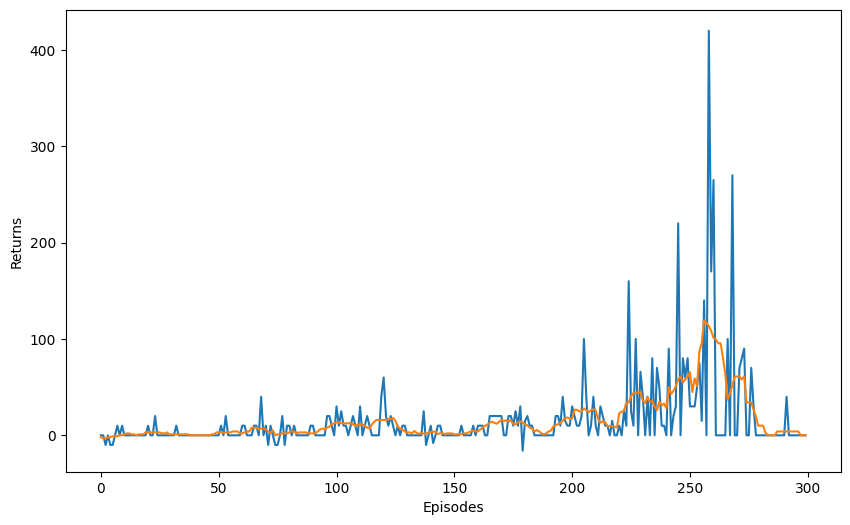

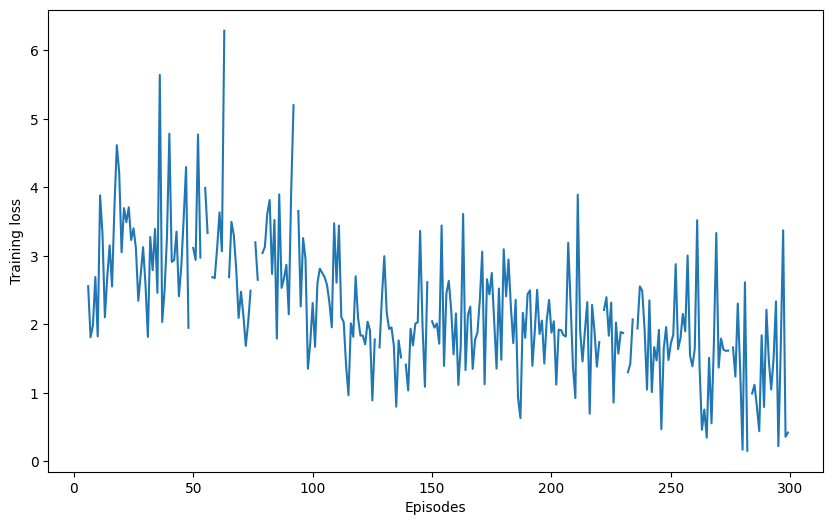

In [13]:
# Parameters
nb_episodes = 300
batch_size = 32

epsilon = 0.5
epsilon_decay = 0.0005

gamma = 0.9

learning_rate = 0.005
buffer_limit = 5000
target_update_period = 100
training_update_period = 4


# Create the environment
env = BombermanEnv(5,5,1,0,1,file_str + "cajas1.txt",'rgb_array')
print(env.observation_space)

# Create the agent
agent = DQNAgent(env, learning_rate, epsilon, epsilon_decay, gamma, batch_size, target_update_period, training_update_period, buffer_limit)

# Train the agent
returns, losses = agent.train(nb_episodes)

# Plot the returns
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.plot(running_average(returns, 10))
plt.xlabel("Episodes")
plt.ylabel("Returns")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel("Episodes")
plt.ylabel("Training loss")
plt.show()

### Primer paso: Determinar parámetros
Para determinar los parámetros se plantea una grilla pequeña con todos los elementos fijos, en este caso, una grila de 5x5 con el agente comenzando en el medio, un enemigo fijo y una caja la cual tiene el target debajo. Con esta base se irán cambiando los parámetros para ir obteniendo mejores resultados en el apreendizaje del agente.

### Parámetros iniciales:
- nb_episodes = 300
- batch_size = 32
- epsilon = 0.5
- epsilon_decay = 0.0005
- gamma = 0.9
- learning_rate = 0.005
- buffer_limit = 5000
- target_update_period = 100
- training_update_period = 4

<div><img src="https://i.ibb.co/yP82ht1/DQN-300-32-0-5-0-0005-0-9-0-005-5000-100-4-Returns.png" width = 700></div>
<div><img src="https://i.ibb.co/m6nbWRS/DQN-300-32-0-5-0-0005-0-9-0-005-5000-100-4-TL.png" width = 700></div>

A partir de esto se empieza a experimentar para encontrar los parámetros adecuados para el aprendizaje del agente. Cabe recalcar que con los parámetros iniciales presentados el agente no logra llegar al target en ningún momento.

### Primer cambio de parámetros:
- nb_episodes = 300
- batch_size = 32
- epsilon = 0.7
- epsilon_decay = 0.0005
- gamma = 0.9
- learning_rate = 0.001
- buffer_limit = 5000
- target_update_period = 100
- training_update_period = 4

En este caso se efectuan 2 cambios en los parámetros, en el epsilon y en el learning_rate, los cuales aumentan y disminuyen respectivamente, en el caso del epsilon aumenta a 0.7 y en el caso del learning_rate disminuye a 0.0001, esto quiere decir que el agente parte desde un punto más cercano al 1, lo que significa que se comportará de manera más aleatoria, además al reducir la tasa de aprendizaje se espera un entrenamiento más estable, sin embargo, podría tardar en converger.

<div><img src="https://i.ibb.co/TB0K0kY/DQN-300-32-0-7-0-0005-0-9-0-001-5000-100-4-Returns.png" width = 700 ></div>
<div><img src="https://i.ibb.co/Q7gxb9G/DQN-300-32-0-7-0-0005-0-9-0-001-5000-100-4-TL.png" width = 700></div>

Aquí se puede ver que la recompensa se incrementa, pero sin embargo, el agente todavía no llega al target.

### Segundo cambio de parámetros:
- nb_episodes = 300
- batch_size = 32
- epsilon = 0.8
- epsilon_decay = 0.0005
- gamma = 0.9
- learning_rate = 0.01
- buffer_limit = 5000
- target_update_period = 100
- training_update_period = 4

Ahora se aumentan ambos parámetros que habían sido variados en el cambio anterior: epsilon y learning_rate. Epsilon aumenta a 0.8 y el learning_rate a 0.01. 

<div><img src="https://i.ibb.co/jDzcSX0/DQN-300-32-0-8-0-0005-0-9-0-01-5000-100-4-Returns.png" width = 700></div>
<div><img src="https://i.ibb.co/QfpXzvF/DQN-300-32-0-8-0-0005-0-9-0-01-5000-100-4-TL.png" width = 700></div>

En este caso se ven claras mejoras con respecto a la recompensa y se ve que el agente logra llegar al target y ganar, en varias ocasiones, sin embargo se puede ver una constante de 0 de recompensa a partir del episodio 250 aproximadamente. 

### Tercer cambio de parámetros:
Para este cambio lo unico que se modificó fue la cantidad de episodios, la cual, se redujó a 250.
- nb_episodes = 250
- batch_size = 32
- epsilon = 0.8
- epsilon_decay = 0.0005
- gamma = 0.9
- learning_rate = 0.01
- buffer_limit = 5000
- target_update_period = 100
- training_update_period = 4

<div><img src="https://i.ibb.co/tBFChh7/Captura-de-Pantalla-2023-12-12-a-la-s-13-11-25.png" width = 700></div>
<div><img src="https://i.ibb.co/d50pdjZ/Captura-de-Pantalla-2023-12-12-a-la-s-13-11-37.png" width = 700></div>

Con estos resultados se puede ver que el agente tiene un aprendizaje relativamente bueno, es por esto que se tomarán estos parámetros y se irá variando el tamaño de la grilla, la cantidad de cajas y enemigos y su aleatoriedad. 



# Desarollo con un entorno de Bomberman donde las cajas y los enemigos son aleatorios

En este caso, se utilizarán los parámetros encontrados en el paso anterior, el que dio mejores resultados fue del tercer cambio de parametros, por lo que, etos son los que se utilizarán en las próximas pruebas.

Episode 250
 total steps: 2280
 length of the episode: 8
 return of the episode: 0
 current loss: 7.059281826019287
 epsilon: 0.2557822847976001


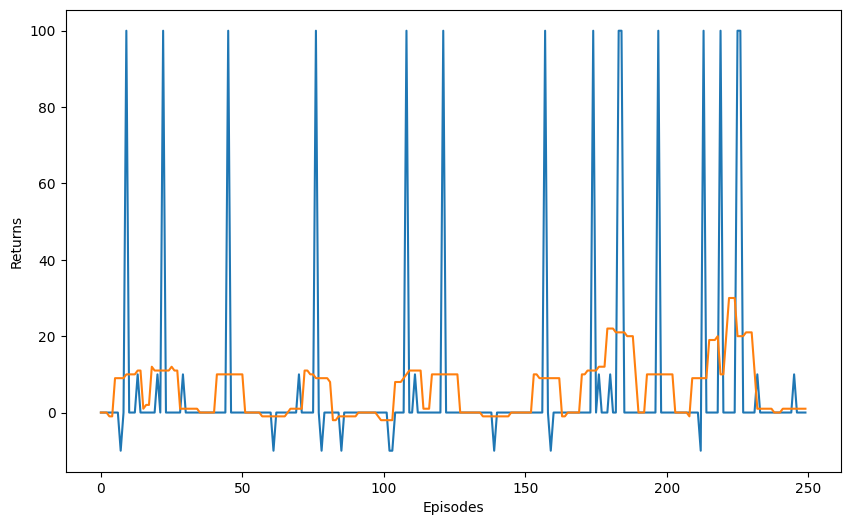

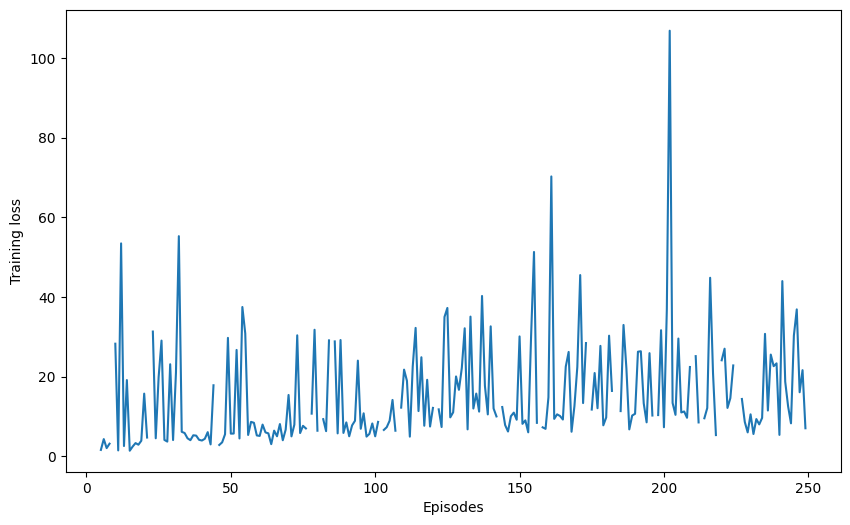

In [31]:
# Parameters
nb_episodes = 250
batch_size = 32

epsilon = 0.8
epsilon_decay = 0.0005

gamma = 0.9

learning_rate = 0.01
buffer_limit = 5000
target_update_period = 100
training_update_period = 4

# Create the environment
env = BombermanEnvRandom(5,5,1,0,1,"",'rgb_array')
print(env.observation_space)

# Create the agent
agent = DQNAgent(env, learning_rate, epsilon, epsilon_decay, gamma, batch_size, target_update_period, training_update_period, buffer_limit)

# Train the agent
returns, losses = agent.train(nb_episodes)

# Plot the returns
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.plot(running_average(returns, 10))
plt.xlabel("Episodes")
plt.ylabel("Returns")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel("Episodes")
plt.ylabel("Training loss")
plt.show()

Con estos resultados podemo ver que el agente ha ganado una mayor cantidad de veces, pero eso tambien se puede deber a la aleatoriedad del posicionamiento de las cosas. Puede que el target haya aparecido más mercano al agente o que los enemigos esten atrapados entre cajas, pero aún así se ve que el agente muestra un aprendizaje.

# Dimensiones de la grila: 8x8 y entorno normal
- Cantidad de cajas rompibles: 6
- Cantidad de enemigos: 5 vertical
- Cantidad de enemigos: 5 horizontal

Episode 250
 total steps: 1549
 length of the episode: 3
 return of the episode: 0
 current loss: 4.87545919418335
 epsilon: 0.3686759367915096


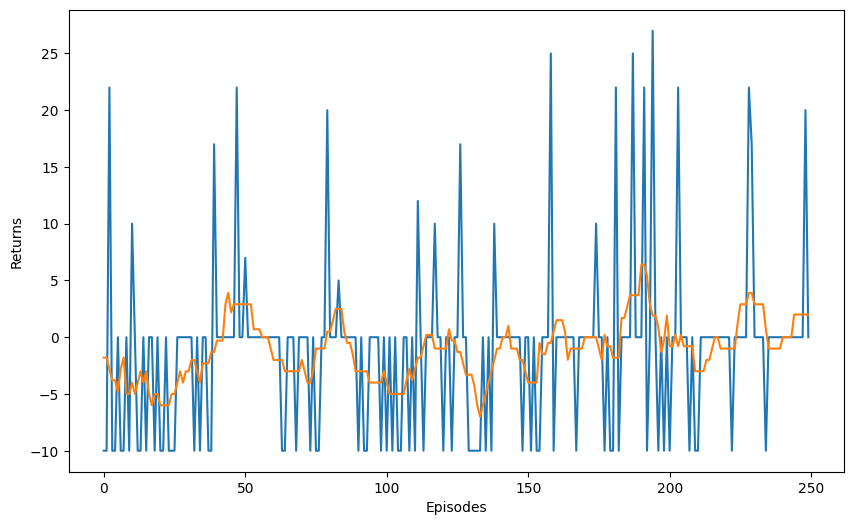

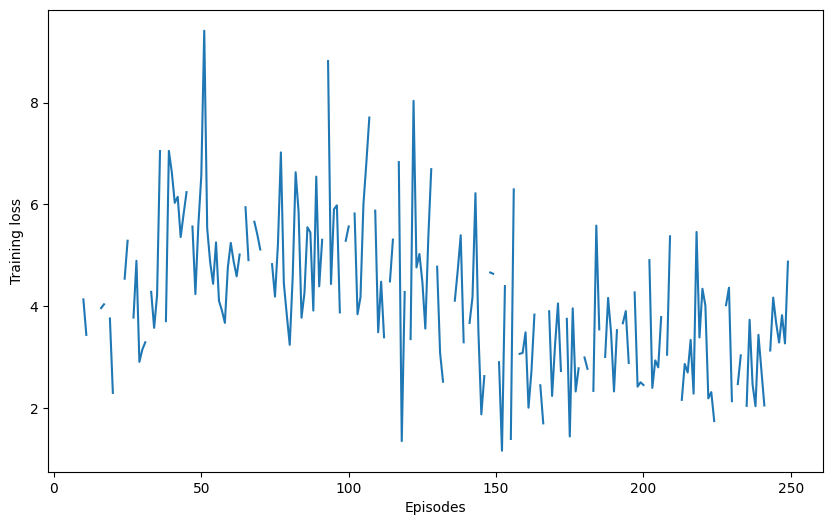

In [38]:
# Parameters
nb_episodes = 250
batch_size = 32

epsilon = 0.8
epsilon_decay = 0.0005

gamma = 0.9

learning_rate = 0.01
buffer_limit = 5000
target_update_period = 100
training_update_period = 4

env = BombermanEnv(8,8,6,5,5,file_str + "cajas2.txt",'rgb_array')

agent = DQNAgent(env, learning_rate, epsilon, epsilon_decay, gamma, batch_size, target_update_period, training_update_period, buffer_limit)

# Train the agent
returns, losses = agent.train(nb_episodes)

# Plot the returns
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.plot(running_average(returns, 10))
plt.xlabel("Episodes")
plt.ylabel("Returns")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel("Episodes")
plt.ylabel("Training loss")
plt.show()

# Dimensiones de la grilla: 8x8 y entorno aleatorio
- Cantidad de cajas rompibles: 6
- Cantidad de enemigos: 5 vertical
- Cantidad de enemigos: 5 horizontal

Episode 250
 total steps: 1880
 length of the episode: 10
 return of the episode: 0
 current loss: 7.150740623474121
 epsilon: 0.31242881439932274


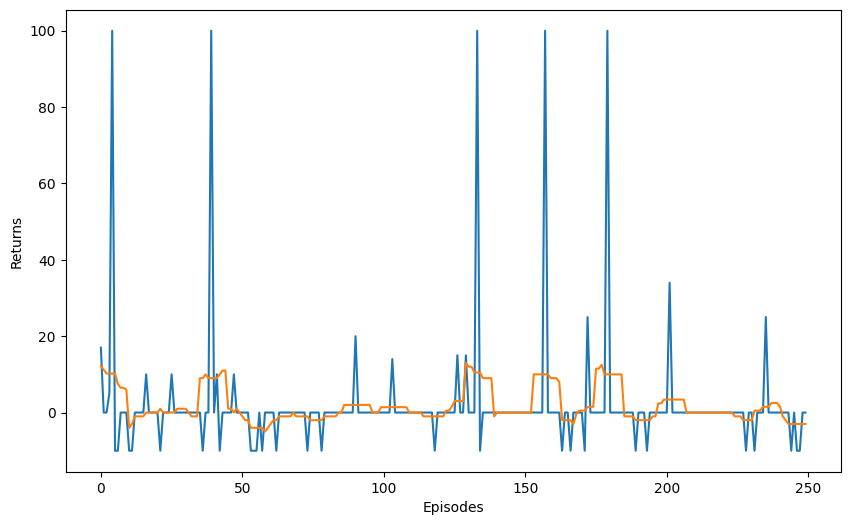

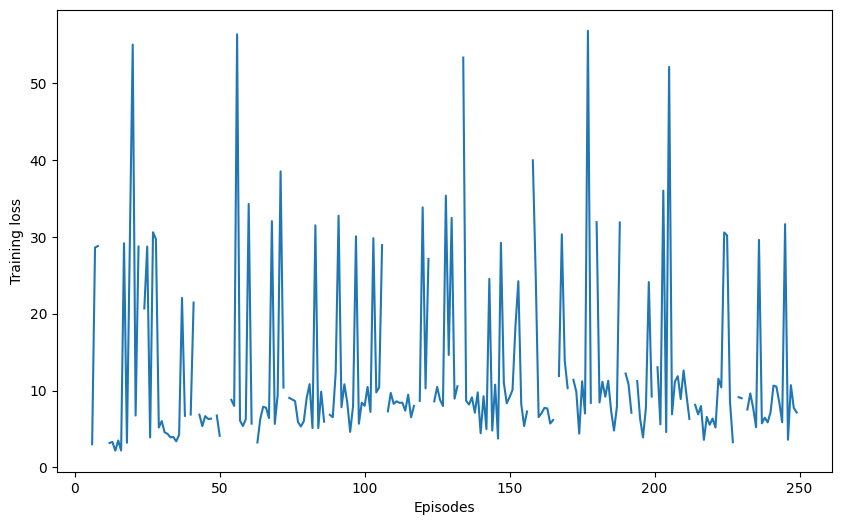

In [39]:
env = BombermanEnvRandom(8,8,6,5,5,"",'rgb_array')

agent = DQNAgent(env, learning_rate, epsilon, epsilon_decay, gamma, batch_size, target_update_period, training_update_period, buffer_limit)

# Train the agent
returns, losses = agent.train(nb_episodes)

# Plot the returns
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.plot(running_average(returns, 10))
plt.xlabel("Episodes")
plt.ylabel("Returns")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel("Episodes")
plt.ylabel("Training loss")
plt.show()

A partir de los resultados anteriores, podemos concluir que el agente presenta una mayor ganancia cuando el posicionamiento de las cajas es de manera aleatoria, esto nuevamente puede ser atribuido a que es posible que haya más posiblidades de que el target haya aparecido cerca del agente.

# Dimensiones de la grilla 8x8 y entorno no aleatorio 
- Cantidad de cajas rompibles: 16
- Cantidad de enemigos: 7 vertical
- Cantidad de enemigos: 7 horizontal


Episode 250
 total steps: 1316
 length of the episode: 2
 return of the episode: 0
 current loss: nan
 epsilon: 0.41424068631790323


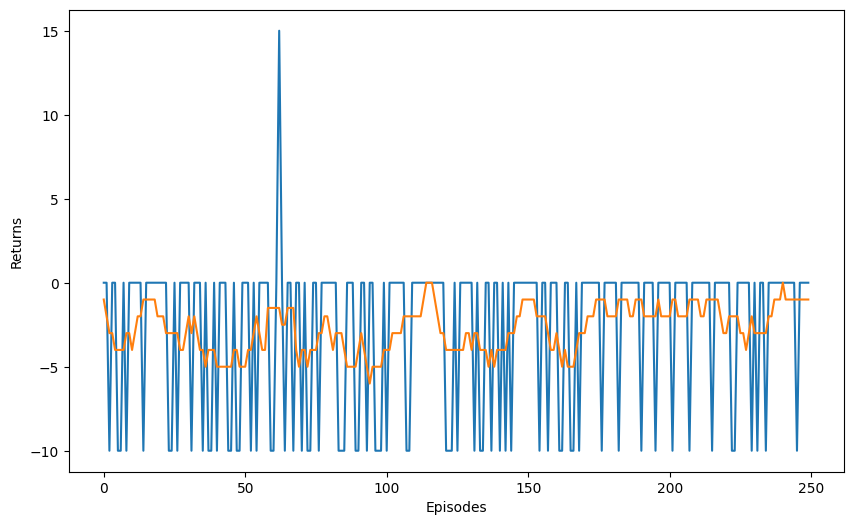

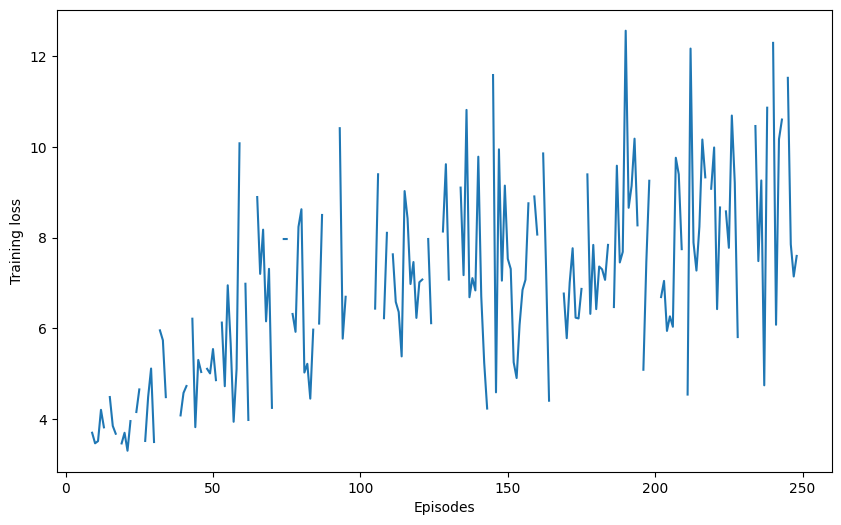

In [41]:
# Parameters
nb_episodes = 250
batch_size = 32

epsilon = 0.8
epsilon_decay = 0.0005

gamma = 0.9

learning_rate = 0.01
buffer_limit = 5000
target_update_period = 100
training_update_period = 4

env = BombermanEnvRandom(8,8,16,7,7,file_str + "cajas3.txt",'rgb_array')

agent = DQNAgent(env, learning_rate, epsilon, epsilon_decay, gamma, batch_size, target_update_period, training_update_period, buffer_limit)

# Train the agent
returns, losses = agent.train(nb_episodes)

# Plot the returns
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.plot(running_average(returns, 10))
plt.xlabel("Episodes")
plt.ylabel("Returns")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel("Episodes")
plt.ylabel("Training loss")
plt.show()

# Dimensiones de la grilla 8x8 y entorno aleatorio 
- Cantidad de cajas rompibles: 16
- Cantidad de enemigos: 7 vertical
- Cantidad de enemigos: 7 horizontal

Se utilizaran estos parámetros para poder comparar con los resultados obtenidos en el lab anterior

Episode 300
 total steps: 2231
 length of the episode: 24
 return of the episode: 0
 current loss: 14.09231702486674
 epsilon: 0.163829971427549


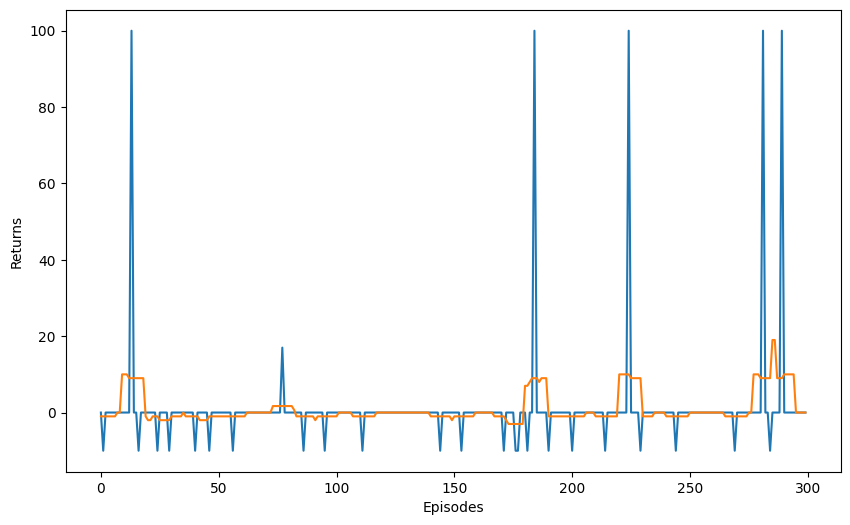

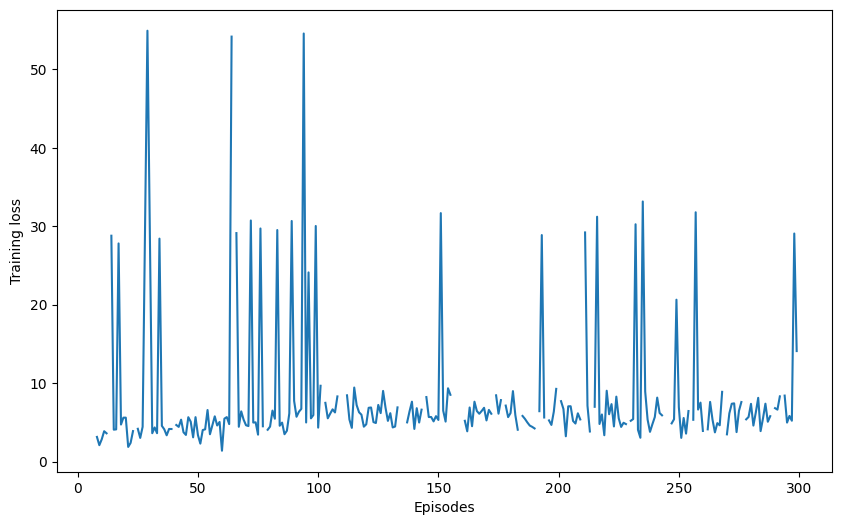

In [14]:
# Parameters
nb_episodes = 250
batch_size = 32

epsilon = 0.8
epsilon_decay = 0.0005

gamma = 0.9

learning_rate = 0.01
buffer_limit = 5000
target_update_period = 100
training_update_period = 4

env = BombermanEnvRandom(8,8,16,7,7,"",'rgb_array')

agent = DQNAgent(env, learning_rate, epsilon, epsilon_decay, gamma, batch_size, target_update_period, training_update_period, buffer_limit)

# Train the agent
returns, losses = agent.train(nb_episodes)

# Plot the returns
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.plot(running_average(returns, 10))
plt.xlabel("Episodes")
plt.ylabel("Returns")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel("Episodes")
plt.ylabel("Training loss")
plt.show()

Se puede ver que en la sección donde el entorno es fijo, el agente tiene muchos problemas para aprender y una gran cantidad de muertes, esto puede ser debido a la gran cantidad de enemigos y la posicion del target pudiendo no estar cerca del agente, donde en comparacion donde las cajas son completamente aleatorias el agente muestra alguna ganancia.

# Comparativa entre el Agente DQN y los resultados obtenidos por el agente Monte Carlo y el agente Q Learning.


## Comparativa de DQN y Monte Carlo
Para la siguiente comparativa se utiliza el entorno más simple correspondiente a:
- grid 5x5
- cajas rompibles fijas: 1
- enemigos verticales: 1
- enemigos horizontales 0
<div><img src="https://i.imgur.com/UOgfp3m.png" width= 1000/></div>

La proxima comparativa se realizará con las sigguientes características del entorno:
- grid 8x8
- cajas rompibles aleatorias: 16
- enemigos horizontales: 7
- enemigos verticales: 7
<div><img src="https://i.imgur.com/SrhAXm6.png" width= 1000/></div>


## Comparativa de DQN y Q Learning
Para la siguiente comparativa se utiliza el entorno más simple correspondiente a:
- grid 5x5
- cajas rompibles fijas: 1
- enemigos verticales: 1
- enemigos horizontales 0
<div><img src="https://i.imgur.com/Z98o7ug.png" width= 1000/></div>

La proxima comparativa se realizará con las siguientes características del entorno:
- grid 8x8
- cajas rompibles aleatorias: 16
- enemigos horizontales: 7
- enemigos verticales: 7
<div><img src="https://i.imgur.com/BHZENKx.png" width= 1000/></div>


# Evauación de capacidad máxima tolerada por el agente y entorno
### Datos utilizados:

- grid: 20x20
- cajas aleatorias: 30
- enemigos verticales: 10
- enemigos horizontales: 10


Episode 250
 total steps: 2582
 length of the episode: 8
 return of the episode: 0
 current loss: 6.7773213386535645
 epsilon: 0.21992550382799955


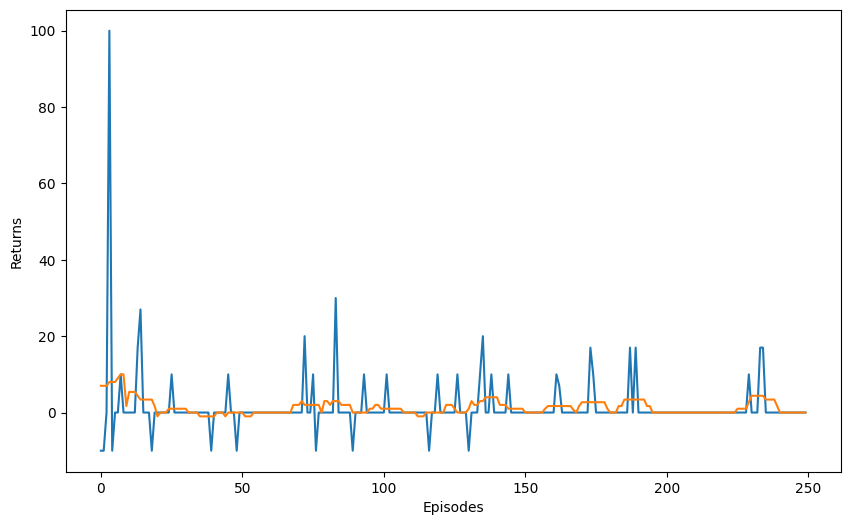

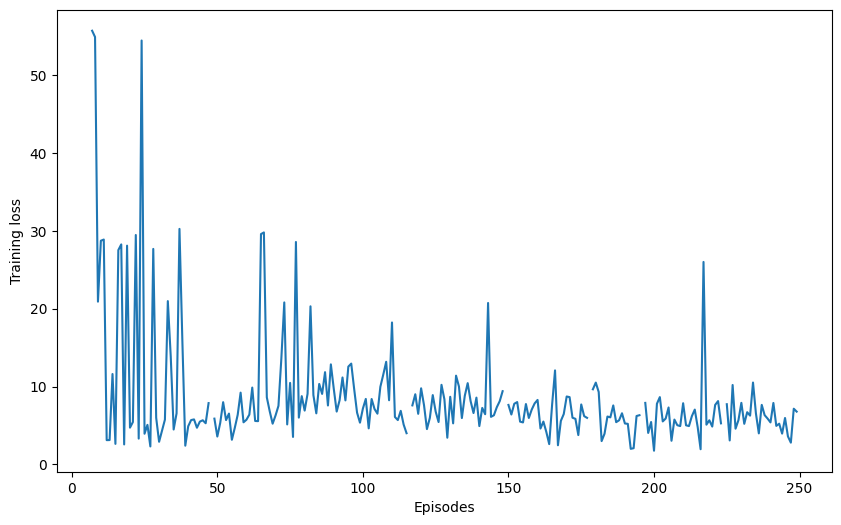

In [42]:
env = BombermanEnvRandom(20,20,30,10,10,"",'rgb_array')

agent = DQNAgent(env, learning_rate, epsilon, epsilon_decay, gamma, batch_size, target_update_period, training_update_period, buffer_limit)

# Train the agent
returns, losses = agent.train(nb_episodes)

# Plot the returns
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.plot(running_average(returns, 10))
plt.xlabel("Episodes")
plt.ylabel("Returns")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel("Episodes")
plt.ylabel("Training loss")
plt.show()

Podemos ver que con un entorno bastante más amplio y con una mayor cantidad de elementos, el agente se ve mucho mas complicado por lo que para poder manejar este tipo de entornos se deba requerir una utilización de una mayor cantidad de episodios y una mayor experimentación de los parametros.

# Conclusión

A partir de los resultados obtenidos y la experimentación realizada, podemos concluir que la utilización de un agente DQN muestra una gran mejora por sobre la implementación de un agente como Monte Carlo y Q Learning. 
Se puede observar que con una gran diferencia de episodios entre DQN y los agentes de la experiencia anterior, DQN es capaz de ofrecer buenos resultados, por lo que si se llegase a utilizar la misma cantidad de episodios que con Monte Carlo o Q Learning, DQN mostrará un mayor aprendizaje a coste de una gran cantidad de recursos.
Entre las ventajas de DQN por sobre Monte Carlo podemos encontrar:
- **Un manejo de problemas de alta dimensionalidad**: DQN al utiliar redes neuronales para aproximar la funcion Q le permite manejar problemas de alta dimensionalidad de manera más efectiva.
- **Generalización a través de experiencias pasadas**: La técnica de experiencia de repetición en DQN permite al agente aprender de experiencias pasadas de forma más eficiente lo que le permite generalizar y mejorar la estabilidad del aprendizaje
- **Exploración y explotación equilibradas**: DQN utiliza estrategias como la política epsilon-greedy para gestionar de manera equilibrada la exploración y explotación del espacio de acción, ayudando a encontrar un equilibrio entre la búsqueda de nuevas acciones y la elección de acciones conocidas.